Set a path to be used to test the steering and throttle control.<br>
Get waypoints from inner ring, path_index = 0 <br>
first_point_guess = (-11, 4)  # You can change this to any (x, y) coordinate<br>
Consider **21. Calculate the angle between points, add  lookahead and speed** when calculating angles<br>
Calculation of Points 3-8:
- Point 3: Located at a distance of 'distance_2_to_3' from Point 2 Forms a right angle with the line segment from Point 1 to Point 2 Direction: 90 degrees counterclockwise from the vector Point 1 to Point 2
- Point 4: Located at a distance of 'distance_2_to_3' from Point 1 Forms a right angle with the line segment from Point 1 to Point 2 Direction: 90 degrees counterclockwise from the vector Point 1 to Point 2
- Point 5: Midpoint of the line segment connecting Point 3 and Point 4
- Point 6: Located at a distance of 'distance_5_to_6' from Point 5 Forms a right angle with the line segment from Point 3 to Point 5 Direction: 90 degrees counterclockwise from the vector Point 3 to Point 5
- Point 7: Located at a distance of 'distance_2_to_3' from Point 6 Forms a right angle with the line segment from Point 5 to Point 6 Direction: 90 degrees clockwise from the vector Point 5 to Point 6
- Point 8: Located at a distance of 'distance_5_to_6' from Point 7 Parallel to the line segment from Point 5 to Point 6 Direction: Opposite to the vector Point 5 to Point 6



Key Distances:
- 'distance_2_to_3': Distance between Points 2 and 3, also used for Points 1 and 4, and Points 6 and 7
- 'distance_5_to_6': Distance between Points 5 and 6, also used for Points 7 and 8

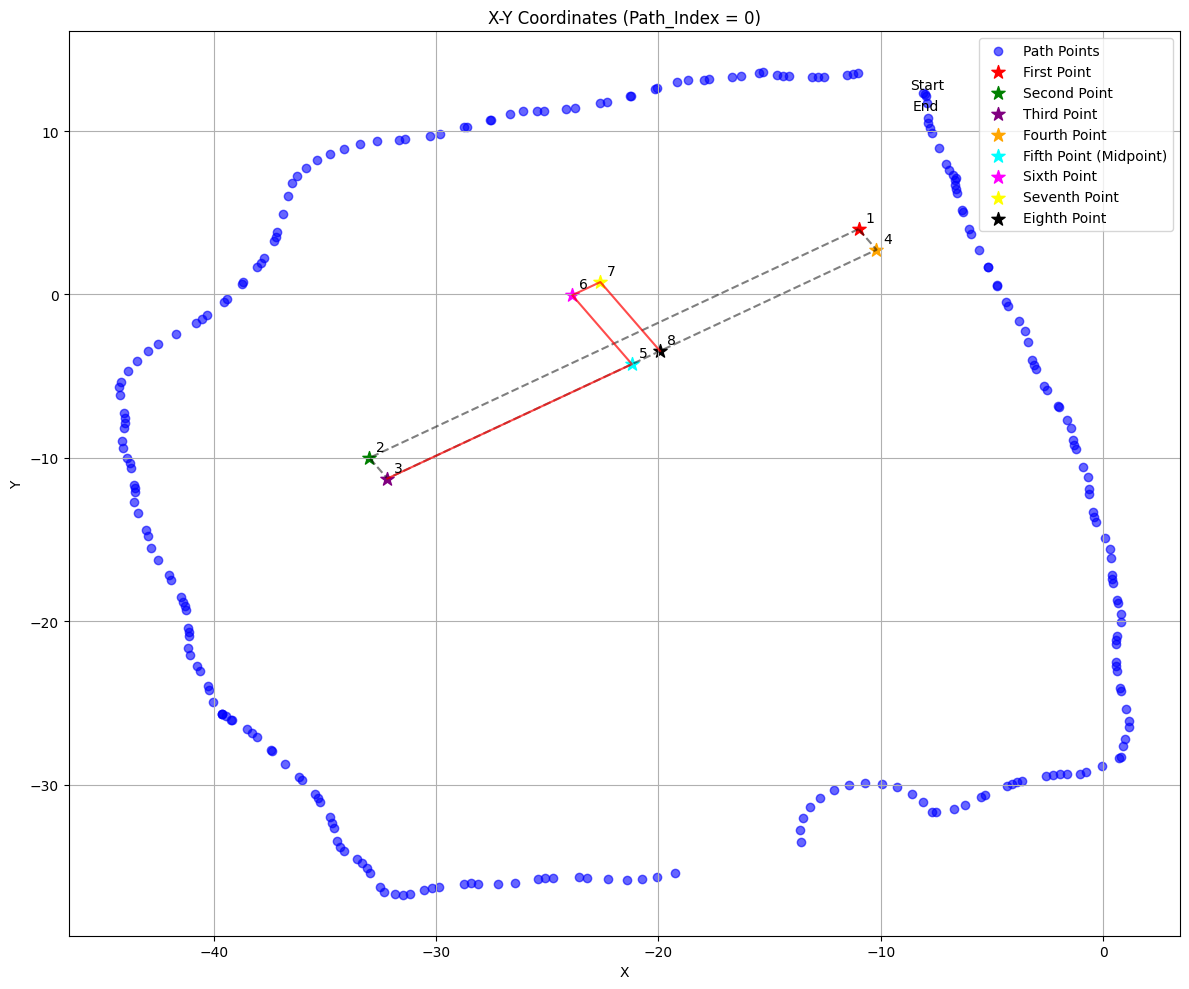

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# File path
xlsx_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx'

# Define the guess points and distances as variables
first_point_guess = (-11, 4)
second_point_guess = (-33, -10)
distance_2_to_3 = 1.5  # Distance between point 2 and point 3 (and point 1 and point 4)
distance_5_to_6 = 5  # Distance from point 5 to 6 (and 7 to 8)

def calculate_rectangle_points(p1, p2, distance):
    v_x = p2[0] - p1[0]
    v_y = p2[1] - p1[1]
    perp_x, perp_y = -v_y, v_x
    length = math.sqrt(perp_x**2 + perp_y**2)
    perp_x, perp_y = perp_x / length * distance, perp_y / length * distance
    p3 = (p2[0] + perp_x, p2[1] + perp_y)
    p4 = (p1[0] + perp_x, p1[1] + perp_y)
    p5 = ((p3[0] + p4[0]) / 2, (p3[1] + p4[1]) / 2)
    return p3, p4, p5

def calculate_additional_points(p3, p5, distance_5_to_6, distance_6_to_7):
    # Vector from p3 to p5
    v_x = p5[0] - p3[0]
    v_y = p5[1] - p3[1]
    
    # Normalize the vector
    length = math.sqrt(v_x**2 + v_y**2)
    v_x, v_y = v_x / length, v_y / length
    
    # Rotate 90 degrees left for direction to p6
    dir_6_x, dir_6_y = -v_y, v_x
    
    # Calculate p6
    p6 = (p5[0] + dir_6_x * distance_5_to_6, p5[1] + dir_6_y * distance_5_to_6)
    
    # Direction for p7 (90 degrees right from p5 to p6)
    dir_7_x, dir_7_y = v_x, v_y
    
    # Calculate p7
    p7 = (p6[0] + dir_7_x * distance_6_to_7, p6[1] + dir_7_y * distance_6_to_7)
    
    # Direction for p8 (opposite of p5 to p6)
    p8 = (p7[0] - dir_6_x * distance_5_to_6, p7[1] - dir_6_y * distance_5_to_6)
    
    return p6, p7, p8

def plot_points(df_filtered, points):
    plt.figure(figsize=(12, 10))
    plt.scatter(df_filtered['X'], df_filtered['Y'], color='blue', alpha=0.6, label='Path Points')
    
    colors = ['red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black']
    labels = ['First Point', 'Second Point', 'Third Point', 'Fourth Point', 'Fifth Point (Midpoint)', 
              'Sixth Point', 'Seventh Point', 'Eighth Point']
    
    for i, (point, color, label) in enumerate(zip(points, colors, labels), 1):
        plt.scatter(point[0], point[1], color=color, s=100, marker='*', label=label)
        plt.annotate(f'{i}', (point[0], point[1]), xytext=(5,5), textcoords='offset points')

    # Draw lines connecting the points
    plt.plot([points[0][0], points[1][0], points[2][0], points[3][0], points[0][0]], 
             [points[0][1], points[1][1], points[2][1], points[3][1], points[0][1]], 'k--', alpha=0.5)
    plt.plot([points[2][0], points[4][0], points[5][0], points[6][0], points[7][0]], 
             [points[2][1], points[4][1], points[5][1], points[6][1], points[7][1]], 'r-', alpha=0.7)

    plt.title('X-Y Coordinates (Path_Index = 0)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)

    first_point = df_filtered.iloc[0]
    last_point = df_filtered.iloc[-1]
    plt.annotate('Start', (first_point['X'], first_point['Y']), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate('End', (last_point['X'], last_point['Y']), textcoords="offset points", xytext=(0,-10), ha='center')

    plt.legend()

    x_coords, y_coords = zip(*points)
    plt.xlim(min(plt.xlim()[0], min(x_coords)), max(plt.xlim()[1], max(x_coords)))
    plt.ylim(min(plt.ylim()[0], min(y_coords)), max(plt.ylim()[1], max(y_coords)))

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    df = pd.read_excel(xlsx_file_path, sheet_name='UpdatedPath')
    df_filtered = df[df['Path_Index'] == 0]

    p3, p4, p5 = calculate_rectangle_points(first_point_guess, second_point_guess, distance_2_to_3)
    p6, p7, p8 = calculate_additional_points(p3, p5, distance_5_to_6, distance_2_to_3)

    all_points = [first_point_guess, second_point_guess, p3, p4, p5, p6, p7, p8]

    plot_points(df_filtered, all_points)

In [3]:
# Move p4 to the end of the list
p4 = all_points.pop(3)  # Remove p4 from its original position
all_points.append(p4)   # Add p4 to the end of the list

# Print the modified all_points list
print("Modified all_points list:")
for i, point in enumerate(all_points, 1):
    print(f"Point {i}: {point}")

# Create DataFrame
points_df = pd.DataFrame(all_points, columns=['X', 'Y'])
points_df.index = range(1, len(points_df) + 1)  # Start index from 1
print("\nPoints DataFrame:")
print(points_df)

Modified all_points list:
Point 1: (-11, 4)
Point 2: (-33, -10)
Point 3: (-32.19468676171026, -11.265492231598161)
Point 4: (-21.19468676171026, -4.265492231598161)
Point 5: (-23.879064222676053, -0.047184792937623676)
Point 6: (-22.61357199107789, 0.7581284453521151)
Point 7: (-19.929194530112095, -3.460178993308422)
Point 8: (-10.194686761710262, 2.734507768401839)

Points DataFrame:
           X          Y
1 -11.000000   4.000000
2 -33.000000 -10.000000
3 -32.194687 -11.265492
4 -21.194687  -4.265492
5 -23.879064  -0.047185
6 -22.613572   0.758128
7 -19.929195  -3.460179
8 -10.194687   2.734508


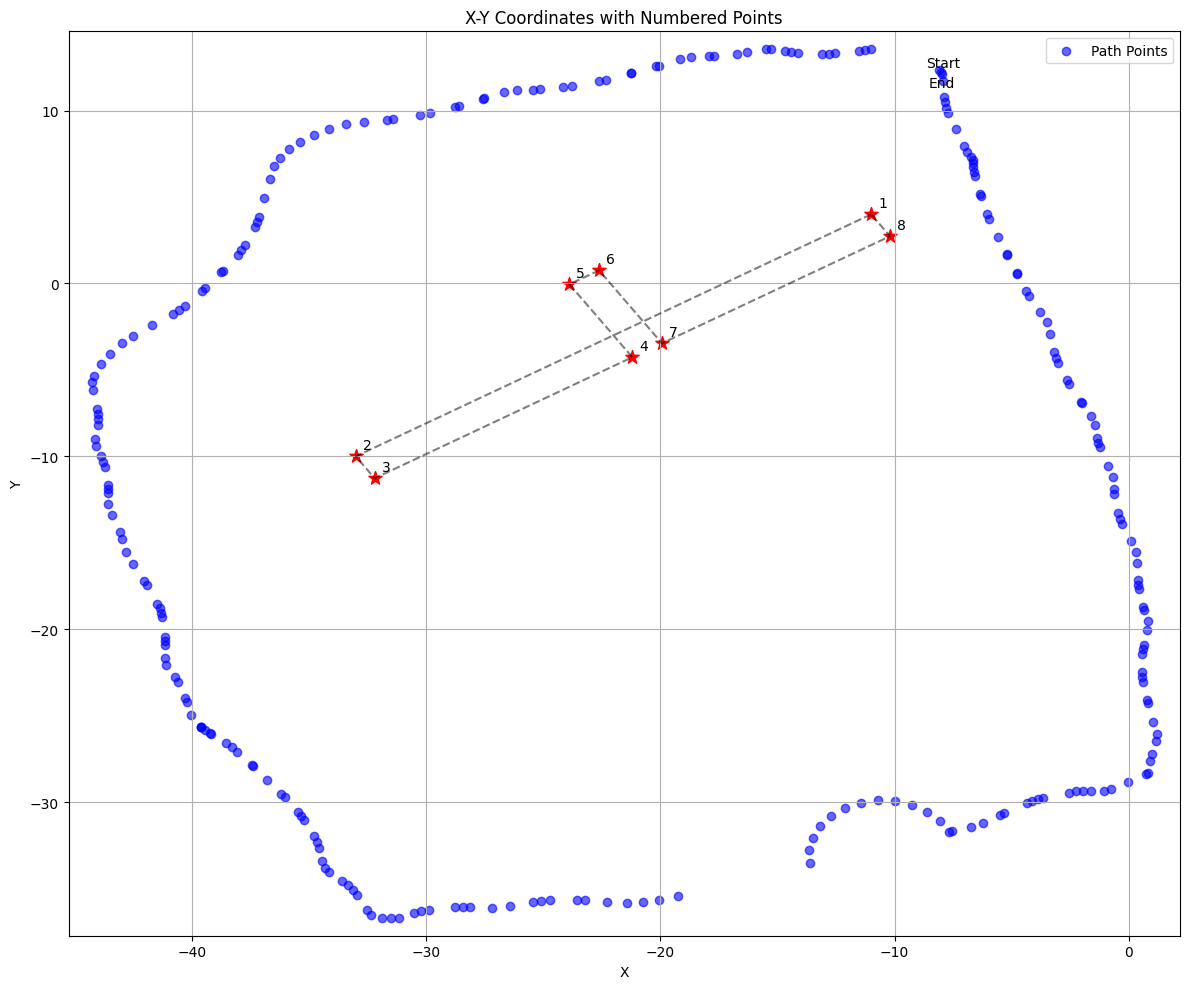

In [4]:
# Plot the points
plt.figure(figsize=(12, 10))

# Plot the original path points
plt.scatter(df_filtered['X'], df_filtered['Y'], color='blue', alpha=0.6, label='Path Points')

# Plot and label the points from the DataFrame
for i, row in points_df.iterrows():
    plt.scatter(row['X'], row['Y'], color='red', s=100, marker='*')
    plt.annotate(f'{i}', (row['X'], row['Y']), xytext=(5,5), textcoords='offset points')

# Draw lines connecting the points
plt.plot(points_df['X'].tolist() + [points_df['X'].iloc[0]], 
         points_df['Y'].tolist() + [points_df['Y'].iloc[0]], 'k--', alpha=0.5)

plt.title('X-Y Coordinates with Numbered Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# Add labels for the first and last path points if needed
first_point = df_filtered.iloc[0]
last_point = df_filtered.iloc[-1]
plt.annotate('Start', (first_point['X'], first_point['Y']), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('End', (last_point['X'], last_point['Y']), textcoords="offset points", xytext=(0,-10), ha='center')

plt.legend()

# Adjust the plot limits to include all points
plt.xlim(min(points_df['X'].min(), df_filtered['X'].min()) - 1, 
         max(points_df['X'].max(), df_filtered['X'].max()) + 1)
plt.ylim(min(points_df['Y'].min(), df_filtered['Y'].min()) - 1, 
         max(points_df['Y'].max(), df_filtered['Y'].max()) + 1)

plt.tight_layout()
plt.show()

In [6]:
import math
import pandas as pd

def calculate_angle(x1, y1, x2, y2):
    '''Calculates the directional angle with respect to the positive X-axis.'''
    angle = math.atan2(y2 - y1, x2 - x1)
    if angle < 0:
        angle += 2 * math.pi
    return round(angle, 2)

def update_df_with_angle_lookahead_speed(df, lookahead, speed):
    # Calculate angles
    angles = []
    for i in range(len(df)):
        if i == len(df) - 1:
            # For the last point, use the same angle as the previous point
            angles.append(angles[-1])
        else:
            x1, y1 = df.iloc[i]['X'], df.iloc[i]['Y']
            x2, y2 = df.iloc[i+1]['X'], df.iloc[i+1]['Y']
            angles.append(calculate_angle(x1, y1, x2, y2))
    
    # Add new columns
    df['angle'] = angles
    df['lookahead'] = lookahead
    df['speed'] = speed
    
    return df

# Use the points_df created earlier
lookahead = 2.5
speed = 0.50

# Update the DataFrame
updated_df = update_df_with_angle_lookahead_speed(points_df, lookahead, speed)

# Round X and Y to 2 decimal places
updated_df['X'] = updated_df['X'].round(2)
updated_df['Y'] = updated_df['Y'].round(2)

# Print the results
print(updated_df.to_string(index=True))

# Write to a .txt file
output_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/updated_points.txt'

# Write the DataFrame to the file without header and index
updated_df.to_csv(output_file_path, sep=' ', header=False, index=False, float_format='%.2f')

print(f"Data has been written to {output_file_path}")

       X      Y  angle  lookahead  speed
1 -11.00   4.00   3.71        2.5    0.5
2 -33.00 -10.00   5.28        2.5    0.5
3 -32.19 -11.27   0.57        2.5    0.5
4 -21.19  -4.27   2.14        2.5    0.5
5 -23.88  -0.05   0.57        2.5    0.5
6 -22.61   0.76   5.28        2.5    0.5
7 -19.93  -3.46   0.57        2.5    0.5
8 -10.19   2.73   0.57        2.5    0.5
Data has been written to /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/updated_points.txt


After adjusting the angles and trimming the lookahead and speed I used the generator to produce this path.<br><br>
<img src="images/path_for_testing.png" alt="Path for testing" width="300px">

The adjusted angles are:<br>
-11.000000   4.000000   3.71<br>
-33.000000 -10.000000   3.71<br>
-32.194687 -11.265492   0.57<br>
-21.194687  -4.265492   1.36<br>
-23.879064  -0.047185   2.14<br>
-22.613572   0.758128   5.28<br>
-19.929195  -3.460179   5.90<br>
-10.194687   2.734508   0.57<br>
<br>I think if I wanted points 4 and 7 to be smoother then I would need to add two additional points.

In [13]:
#!/usr/bin/env python

import pandas as pd
import math
import dubins

def generate_path(x0, y0, x1, y1, theta0, theta1, turning_radius, step_size):
    q0 = (x0, y0, theta0)
    q1 = (x1, y1, theta1)
    continuous_path = dubins.shortest_path(q0, q1, turning_radius)
    calculated_path_segment, _ = continuous_path.sample_many(step_size)
    return calculated_path_segment

def calculate_curvature(p1, p2, p3):
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    x3, y3 = p3[0], p3[1]

    a = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    b = math.sqrt((x2 - x3)**2 + (y2 - y3)**2)
    c = math.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    s = (a + b + c) / 2

    area = s * (s - a) * (s - b) * (s - c)
    if area <= 0:
        return 0

    radius = a * b * c / (4 * math.sqrt(area))
    curvature = 1 / radius if radius != 0 else 0

    return curvature

def calculate_curvature_and_update_path(drive_path, alternate_lookahead, curvature_threshold):
    updated_drive_path = []
    for i in range(1, len(drive_path) - 1):
        p1, p2, p3 = drive_path[i - 1], drive_path[i], drive_path[i + 1]
        curvature = calculate_curvature(p1, p2, p3)

        if curvature > curvature_threshold:
            lookahead = alternate_lookahead
        else:
            lookahead = p2[3]

        updated_drive_path.append((p2[0], p2[1], p2[2], lookahead, p2[4]))

    return updated_drive_path

def main():
    def read_waypoints(input_file_path):
        df = pd.read_csv(input_file_path, sep=' ', header=None, names=['x', 'y', 'theta', 'lookahead', 'speed'])
        return df.values.tolist()

    def generate_drive_path(waypoints, turning_radius, step_size, lookahead, speed):
        drive_path = []
        x0, y0, theta0 = 0.0, 0.0, 0.0
        for idx, point in enumerate(waypoints):
            x1, y1, theta1 = point[0], point[1], point[2]
            if idx == 0:
                x0, y0, theta0 = x1, y1, theta1
                drive_path.append((x1, y1, theta1, lookahead, speed))
                continue
            try:
                calculated_path_segment = generate_path(x0, y0, x1, y1, theta0, theta1, turning_radius, step_size)
                for segment in calculated_path_segment:
                    segment += (lookahead, speed)
                    drive_path.append(segment)
            except RuntimeError as e:
                print(f"Error generating path from ({x0}, {y0}, {theta0}) to ({x1}, {y1}, {theta1})")
                print(f"Error message: {str(e)}")
                # Add the endpoint directly if path generation fails
                drive_path.append((x1, y1, theta1, lookahead, speed))
            x0, y0, theta0 = x1, y1, theta1
        return drive_path

    def write_output_txt(output_file_path, drive_path):
        with open(output_file_path, 'w') as f:
            for p in drive_path:
                f.write(f"{p[0]:.2f} {p[1]:.2f} {p[2]:.2f} {p[3]:.2f} {p[4]:.2f}\n")
        return len(drive_path)

    # main routine
    turning_radius = 1.3
    step_size = 0.3
    lookahead = 2.5
    alternate_lookahead = 1.0
    curvature_threshold = 0.02
    speed = 0.75

    input_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/updated_points.txt'
    output_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/path_dubins_for_steering_test.txt'

    waypoints = read_waypoints(input_file_path)
    drive_path = generate_drive_path(waypoints, turning_radius, step_size, lookahead, speed)
    print("done with generate_drive_path")

    drive_path = calculate_curvature_and_update_path(drive_path, alternate_lookahead, curvature_threshold)
    print("done with calculate_curvature_and_update_path")

    total_count = write_output_txt(output_file_path, drive_path)
    print(f"Output file: {output_file_path}")
    print("Record count:", total_count, "turning_radius:", turning_radius, "step_size:", step_size)
    print("eoj")

if __name__ == "__main__":
    main()

done with generate_drive_path
done with calculate_curvature_and_update_path
Output file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/path_dubins_for_steering_test.txt
Record count: 257 turning_radius: 1.3 step_size: 0.3
eoj


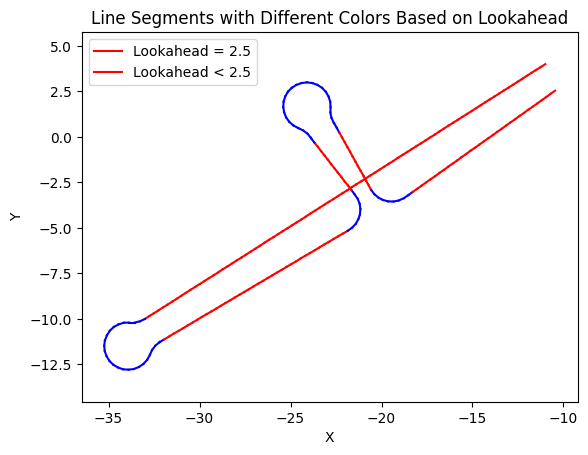

In [15]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to read data from a text file
def read_data(file_path):
    df = pd.read_csv(file_path, sep=' ', header=None, names=['x', 'y', 'theta', 'lookahead', 'speed'])
    points = df[['x', 'y', 'lookahead']].values.tolist()
    return points

# Function to plot the data
def plot_data(points):
    for i in range(len(points) - 1):
        x1, y1, lookahead1 = points[i]
        x2, y2, lookahead2 = points[i + 1]
        # Choose color based on lookahead value
        color = 'red' if lookahead1 == 2.5 else 'blue'
        # Plotting the line segment
        plt.plot([x1, x2], [y1, y2], color=color)

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Line Segments with Different Colors Based on Lookahead')
    plt.axis("equal")
    
    # Add legend
    plt.legend(['Lookahead = 2.5', 'Lookahead < 2.5'])

    # Show the plot
    plt.show()

# Main
file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/path_dubins_for_steering_test.txt'
data_points = read_data(file_path)
plot_data(data_points)

**Using the path just created**<br>
<br>The file 'input_path.txt' is the default path used for the program 'pure_pursuit.cpp' so I need to copy the output from above into that file.

In [17]:
import shutil
import os

# Source file 'file_path' from the cell above

# Destination file path
destination_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/input_path.txt'

try:
    # Create the destination directory if it doesn't exist
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    
    # Copy the file
    shutil.copy2(file_path, destination_path)
    print(f"File successfully copied to {destination_path}")
except IOError as e:
    print(f"Unable to copy file. Error: {e}")
except:
    print("Unexpected error occurred while copying file")

File successfully copied to /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/input_path.txt
